<a href="https://colab.research.google.com/github/LeyloJohnny/Computational-Neuroscience/blob/main/Fast_dim_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#get data from google drive
!gdown --id 1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
#unzip data
!unzip 'NewData.zip'

Downloading...
From: https://drive.google.com/uc?id=1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
To: /content/NewData.zip
127MB [00:01, 89.5MB/s]
Archive:  NewData.zip
  inflating: Cluster.pkl             
replace BN.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BN.pkl                  
  inflating: SFA.pkl                 


We have 20 intervals, each 100ms long. 

The spike count matrix has the shape: (3, 20, 40) representing 3 models, 20 intervals, and 40 neurons. 

Model 0 has 12 principal components.
Model 0 has 11 dimensions based on dimensionality measure used by Mazzucato et al.
Model 1 has 7 principal components.
Model 1 has 5 dimensions based on dimensionality measure used by Mazzucato et al.
Model 2 has 8 principal components.
Model 2 has 4 dimensions based on dimensionality measure used by Mazzucato et al.
here_now
We have 25 intervals, each 100ms long. 

The spike count matrix has the shape: (3, 25, 40) representing 3 models, 25 intervals, and 40 neurons. 

Model 0 has 14 principal components.
Model 0 has 14 dimensions based on dimensionality measure used by Mazzucato et al.
Model 1 has 10 principal components.
Model 1 has 7 dimensions based on dimensionality measure used by Mazzucato et al.
Model 2 has 10 principal components.
Model 2 has 4 dimensions based on dimensionality measure used by Ma

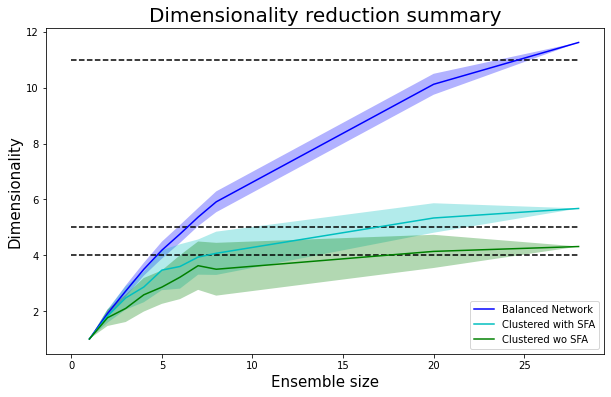

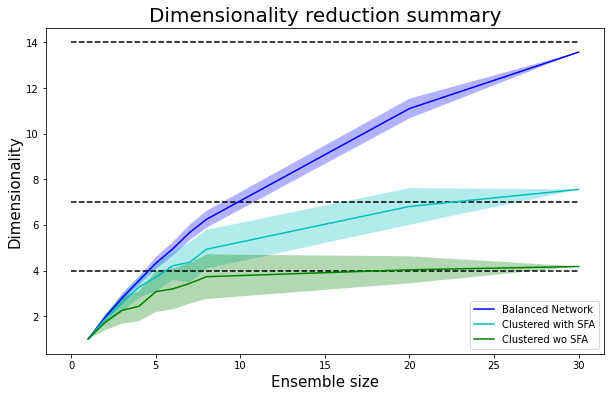

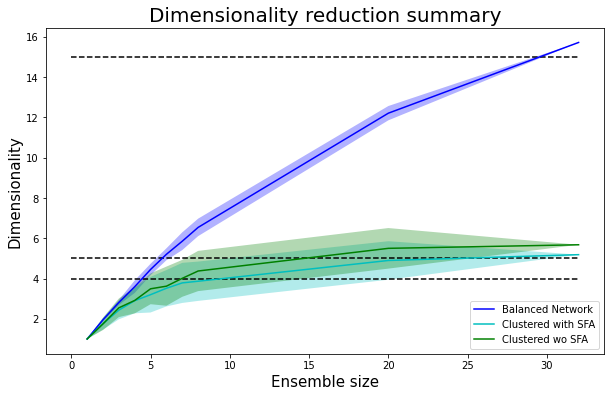

In [18]:
#imports
import pickle
import numpy as np
import matplotlib.pyplot as plt
#imports required for pca
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
from operator import add
from operator import sub

#define variables

time_ranges = [2000, 2500, 3000]
starting_times = [0, 0, 0]
neuron_ID = 0
nNeurons = 40
window = 100
t_range = 0
colors = ['b', 'c', 'g']

#access data

#create a list of model name strings
models = ['BN.pkl', "SFA.pkl", "Cluster.pkl"]

#create a list of model names
model_names = ["Balanced Network", "Clustered with SFA", "Clustered wo SFA"]

#create lists to store model data
models_x = []
models_y = []

#for all models
for i in range(len(models)):

  #open pickle file
  with open(models[i], 'rb') as f:
    #get x (actual data: time * neuron id)
    x = pickle.load(f)
    #get y (information on data, such as inhibitory/excitatory neurons, clusters, etc.)
    y = pickle.load(f)
    #add x and y to the models lists
    models_x.append(x)
    models_y.append(y)

for t_range in range(len(time_ranges)):

      time_range_models = []

      time_range = time_ranges[t_range]
      starting_time = starting_times[t_range]

      for model in range(len(models)):
        #set condition: returns True for time <= 5 s
        condition = [True if i >starting_time and i <= time_range + starting_time else False for i in models_x[model][0]]

        #extract new x and y values for array based on condition
        new_x = np.extract(condition, models_x[model][0])
        new_y = np.extract(condition, models_x[model][1])

        new = [new_x, new_y]

        time_range_models.append(new)

      one_cluster = []

      for model in range(len(models)):

        condition = [True if i > neuron_ID and i <= neuron_ID+nNeurons else False for i in time_range_models[model][1]]

        #extract new x and y values for array based on condition
        new_x = np.extract(condition, time_range_models[model][0])
        new_y = np.extract(condition, time_range_models[model][1])

        new = [new_x, new_y]

        one_cluster.append(new)

      neuron_array = np.arange(neuron_ID, neuron_ID+nNeurons, 1)
      
      #define a time window (in milliseconds)

      neurons = nNeurons

      file_name = "spike_count_matrix_tr_" + str(time_range) + "_tw_" + str(window)

      #calculate number of intervals based on recorded time span / time window
      intervals = int(time_range/window)

      #define which neurons to focus on (here: only excitatory neurons 0 - 4000)
      #neurons = int(np.max(one_cluster[i][1])+1) 

      #how many intervals do we have?
      print("We have " + str(intervals) + " intervals, each " + str(window) + "ms long. \n")

      spike_count_matrix = np.zeros((len(models), intervals, neurons))

      #for every model
      for i in range(len(models)):
        #get the data of the current model
        current_model_x = np.array(one_cluster[i])

        #create a zeros array with size time * neurons (5000*4000)
        spike_counts = np.zeros((intervals, neurons))

        #for every interval
        for j in range(intervals):

          #get the indices of time points within the current interval
          interval_time_points = np.where(np.logical_and(window*j + starting_time <= current_model_x[0], current_model_x[0] < window*(j+1)+starting_time))

          #get data indexed by current interval
          interval_data = current_model_x[1][interval_time_points]

          #for every neuron
          for k in range(neurons):

              #get the indices of the current neuron within the defined time interval
              current_neuron = np.where(interval_data == neuron_array[k])

              #get the number of spikes based on the amount of neuron indices within the defined time interval
              spikes = current_neuron[0].shape[0]

              #add spikes number to spike count matrix
              spike_counts[j, k] = spikes

        #add spike count matrix for every model
        spike_count_matrix[i] = spike_counts

      np.save(file_name, spike_count_matrix)

      #print data
      print("The spike count matrix has the shape: " + str(spike_count_matrix.shape) + " representing " + 
            str(spike_count_matrix.shape[0]) + " models, " + str(spike_count_matrix.shape[1]) + " intervals, and " + str(spike_count_matrix.shape[2]) + " neurons. \n")
      
      #define titles for columns and rows in the dataframe that will be generated from the spike count matrix
      cols = ['Neuron{}'.format(int(col+1)) for col in range(neurons)] #rows represent the neurons (= features)
      rows = ['Interval{}'.format(int(row+1)) for row in range(intervals)] #columns represent the time intervals/time bins (= samples)

      #create list for the data to be analyzed for each model
      models_data = []

      #for every model'
      for model in range(len(models)):
        #create a dataframe from the spike count matrix
        current = spike_count_matrix[model]
        data = pd.DataFrame(data = current, index = rows, columns = cols)
        #add the dataframe to the list (containing one dataframe per model)
        models_data.append(data)

      silent_neurons = []
      all_models_silent = []

      for model in range(len(models)):
        model_silent_neurons = []
        for neuron in range(neurons):
          if models_data[model].iloc[:, neuron].sum(0) == 0:
            model_silent_neurons.append(neuron+1)
        silent_neurons.append(model_silent_neurons)
      
      for model in range(len(models)):
        for neuron_number in range(len(silent_neurons[model])):
          neuron = silent_neurons[model][neuron_number]
          del models_data[model]["Neuron" + str(neuron)]  
      
      min_neurons = np.min([models_data[0].shape[1], models_data[1].shape[1], models_data[2].shape[1]])

      shortened_data = []

      for model in range(len(models)):
        keep_sample = models_data[model].sample(min_neurons, axis = 'columns')
        shortened_data.append(keep_sample)

      #create list for the pca results for each model
      pca_results = []
      #create list for the eigenvalues for each model
      eigenvalues = []
      #create list for the variance ratio for each model
      variance_ratio = []
      #create list for the number of principal components for each model (using a certain variance)
      n_components = []
      #create list for the cumulative variance
      cumulative_variance = []

      #initiate pca
      pca = PCA()

      #for every model
      for i in range(len(models)): 
        #standardize data: transform the data onto unit scale (mean = 0 and variance = 1)
        standardized = StandardScaler().fit_transform(models_data[i])
        #fit the data
        pca.fit(standardized)

        #add eigenvalues to eigenvalue list
        eigenvalues.append(pca.explained_variance_)
        #add explained variance ratio to variance ratio list
        variance_ratio.append(pca.explained_variance_ratio_)

        #get the pca results
        final_data = pca.transform(models_data[i])
        #add the resulting data to the list of results for each model
        pca_results.append(final_data)

        #calculate cumulative variance:

        #set cumulative to zero for every new model
        cumulative = 0
        #create empty array for cumulative variance of the current model
        current_cumulative = np.zeros(len(variance_ratio[i]))
        #for every principal component (all variance values)
        for variance in range(len(variance_ratio[i])):
          #add the current components variance to the cumulative value
          cumulative += variance_ratio[i][variance]
          #set the current models cumulative value to the current cumulative
          current_cumulative[variance] = cumulative
        #append current models cumulative to list of all models cumulative variance
        cumulative_variance.append(current_cumulative)

        #calculate the amount of principal components describing a defined amount of explained variance (e.g. 90%)
        current_components = np.where(cumulative_variance[i] < 0.9)
        n_components.append(int(current_components[0].shape[0]) + 1)
      
      dim_reduction_number = []

      for model in range(len(models)): 
        #how many principal components do we have?
        print("Model " + str(model) + " has " + str(n_components[model]) + " principal components.")
        #set the current value to zero
        current = 0

        #for every principal component
        for j in range(n_components[model]):
          #(eigenvalue/total amount of variance explained)²
          squared = (eigenvalues[model][j]/sum(eigenvalues[model][:]))**2
          #add the result to the current value
          current += squared

        #divide 1 by the sum of all results
        result = 1/current

        dim_reduction_number.append(str(int(result)))

        #print the results
        print("Model " + str(model) + " has " + str(int(result)) + " dimensions based on dimensionality measure used by Mazzucato et al.")


      #what sample sizes do you want to generate?

      #initiate pca
      pca = PCA()

      all_steps = []

      print("here_now")

      models_data = shortened_data

      #every possible sample size from 1 to 99 (small steps, every sample)
      small_steps = np.linspace(1, int(nNeurons/5)-1, int(nNeurons/5)-1)
      #define big steps from 100 to 2000 (every 200)
      big_steps = np.linspace(int(nNeurons/5), int(nNeurons/2), int(int(nNeurons/2)/10))

      steps = np.concatenate((small_steps, big_steps))


      for model in range(len(models)):
        #get the last possible sample number
        last_step = np.array(models_data[model].shape[1])
        #concatenate all the sample sizes to one list
        all_steps.append(np.append(steps, last_step))

      ensemble_size = all_steps[0].shape[0]

      #define how many repeats you want to have for your random sampling
      repeats = 50

      #create list for all eigenvalues
      all_eigenvalues = []

      #for all models
      for model in range(len(models)):
        #create list for eigenvalues of each sample
        eigenvalue_samples = []

        #for all samples
        for sample in range(ensemble_size):
          #create list for all repeats of the current sample
          eigenvalue_repeats = []

          #for every repeat
          for repeat in range(repeats):
            #get a random sample of neurons of the current sample size 
            repeat_sample = models_data[model].sample(int(all_steps[model][sample]), axis = 'columns')

            #standardize data: transform the data onto unit scale (mean = 0 and variance = 1)
            standardized = StandardScaler().fit_transform(repeat_sample)
            #fit the data

            import warnings 
            with warnings.catch_warnings():
              warnings.filterwarnings('error')
              try:
                pca.fit(standardized)
              except Warning as e:
                print("Dataset " + str(data))
                print("Model " + str(model))
                print("Sample " + str(sample))
                print(repeat_sample.sum(0))
                print("Repeat " + str(repeat))
            
            #calculate eigenvalues and add to list of all repeats
            eigenvalue_repeats.append(pca.explained_variance_)
          #add lists of eigenvalues for each repeat to the list for each sample
          eigenvalue_samples.append(eigenvalue_repeats)
        #add list of eigenvalues for each sample to the list of eigenvalues for all models
        all_eigenvalues.append(eigenvalue_samples)











      #create list for all dimensionality values for every model
      all_dimensionality = []

      #for every model
      for model in range(len(models)): 
          #access the eigenvalues of the current model
          current_model = all_eigenvalues[model]
          #create list for the dimensionality values of each sample
          samples = []

          #for every sample
          for sample in range(ensemble_size):
            #access the eigenvalues of the current sample
            current_sample = current_model[sample]
            #create a list for the dimensionality values of the current sample's repeats
            all_repeats = []

            #for every repeat
            for repeat in range(repeats):
              #set the current value to zero
              current = 0
              #calculate the total variance of all neuron's eigenvalues within the current sample and repeat
              total_variance = sum(current_sample[repeat][:])

              #if the total variance is not zero, calculate dimensionality:
              if total_variance != 0:
                #for every neurons within the current sample and repeat
                for neuron in range(len(current_sample[repeat])):
                  #squared = (eigenvalue/total amount of variance explained)²
                  squared = (current_sample[repeat][neuron]/total_variance)**2  
                  #add the result to the current value
                  current += squared

                #calculate dimensionality: 1 divided by current value
                dimensionality = 1/current

              #else (if the total variance is zero)
              else:
                print("weird...")
                #set the result to zero to avoid division by zero
                dimensionality = 0

              #add the current dimensionality to the list of all repeats  
              all_repeats.append(dimensionality)
            #calculate mean and standard deviation for all repeats of the current sample
            mean = np.mean(all_repeats[:])
            std = np.std(all_repeats[:])
            #add means and stds as a tuple to a list for all samples
            samples.append((mean, std))
          #add all dimensionality values from all samples to the list of all dimensionalities
          all_dimensionality.append(samples)
          

      #define figure fig with a certain size
      fig = plt.figure(figsize = (10,6))
      #define axis, two axis, index position = 1
      ax = fig.add_subplot(1,1,1) 
      #set labels and title of figure
      ax.set_xlabel('Ensemble size', fontsize = 15)
      ax.set_ylabel('Dimensionality', fontsize = 15)
      ax.set_title('Dimensionality reduction summary', fontsize = 20)

      #for tuple of target and color: (target, color)
      for model in range(len(models)):
          #get lists of all means and standard deviations
          all_means = [x[0] for x in all_dimensionality[model]]
          all_std = [x[1] for x in all_dimensionality[model]]

          #calculate positive and negative error
          pos_err = list(map(add, all_means, all_std)) 
          neg_err = list(map(sub, all_means, all_std))

          #plot the data
          ax.plot(all_steps[model], all_means, color = colors[model], label = model_names[model])
          #fill area of positive and negative errors
          #ax.hlines(float(dim_reduction_number[model]),0, all_steps[model][-1],ls='--',color='k')
          ax.fill_between(all_steps[model], pos_err, neg_err, facecolor = colors[model], alpha=0.3)
          plt.legend(loc = "lower right")